# Measuring the "classicality" of RusDraCor plays

Based on [Sperantov 1998](https://rvb.ru/philologica/05/05sperantov.htm)

## Data preparation

- plays in a corpus,

- for each play in a corpus:

    - year,
    
    - amount of `<stage>` entries,

    - amount of `sp` entries,

    - stage directions themselves

In [1]:
import json
import requests

**Quantitative data** — titles and amounts:

In [2]:
%%time
plays = []
years = []

corpus_response = requests.get("https://dracor.org/api/corpora/rus")
for play_json in corpus_response.json()["dramas"]:
    plays.append(play_json["id"])
    years.append(play_json["yearNormalized"])
print(len(plays))

141
CPU times: user 43.3 ms, sys: 11.8 ms, total: 55.1 ms
Wall time: 658 ms


In [3]:
%%time
# <stage> entries
stage_counts = []

for play in plays:
    stage_response = requests.get("https://dracor.org/api/corpora/rus/play/{}/stage-directions".format(play))
    stage_count = len(stage_response.text.split("\n"))
    stage_counts.append(stage_count)
print(len(stage_counts))

141
CPU times: user 4.2 s, sys: 270 ms, total: 4.47 s
Wall time: 1min 8s


In [4]:
%%time
# <sp> entries
sp_counts = []

for play in plays:
    sp_reponse = requests.get("https://dracor.org/api/corpora/rus/play/{}/spoken-text".format(play))
    sp_count = len(sp_reponse.text.split("\n"))
    sp_counts.append(sp_count)
print(len(sp_counts))

141
CPU times: user 4.44 s, sys: 314 ms, total: 4.76 s
Wall time: 1min 44s


Quick smoke test — is the data extracted properly?

In [5]:
for i, play in enumerate(plays[:5]):
    print("Play: {}\n\tyear: {}\n\tstage: {}\n\tsp: {}".format(play, years[i], stage_counts[i], sp_counts[i]))

Play: andreyev-ne-ubiy
	year: 1913
	stage: 341
	sp: 972
Play: andreyev-mysl
	year: 1914
	stage: 233
	sp: 667
Play: babel-zakat
	year: 1927
	stage: 293
	sp: 658
Play: babel-marija
	year: 1935
	stage: 137
	sp: 595
Play: blok-korol-na-ploschadi
	year: 1907
	stage: 133
	sp: 414


*(looks like it is)*

Moving on to **linguistic data** — stage directions. They will be stored at `./data/stage/raw`.

In [6]:
import os

In [7]:
stage_raw_path = "./data/stage/raw"

if not os.path.exists(stage_raw_path):
    os.mkdir(stage_raw_path)

Actually, I used the very same API request when counting the amount of stage directions in a play, but in order to make the notebook more straight-forward and easy to read, let's do this again:

In [8]:
# %%time
# for play in plays:
#     stage_response = requests.get("https://dracor.org/api/corpora/rus/play/{}/stage-directions".format(play))
#     play_stage_text = stage_response.text
#     play_stage_path = os.path.join(stage_raw_path, play+".txt")
#     with open(play_stage_path, "w", encoding="utf-8") as play_stage_file:
#         play_stage_file.write(play_stage_text)

When running the notebook more than once, skip this cell due to the fact that you already have the directions.

I won't keep the directions' lists all the time in a Python list due to memory issues.

#### Side note:
to convert everything into a dataframe later, everything will be stored as a dictionary.

In [9]:
aggregated_plays_dict = {
    "play": plays,
    "year": years,
    "sp": sp_counts,
    "stage": stage_counts
}

## Metric 1: &emsp; Stage directions' density

**Question:** How frequently stage directions occur in a given play?

**Originally calculated as:** $P = (n/N)\times100$

$P$ — density coefficient,

$n$ — number of stage directions in a text,

$N$ — number of verses

**Adaptation:** take $N$ as a number of preformance texts, tagged by `<sp>` tag (see [TEI-P5](http://www.tei-c.org/release/doc/tei-p5-doc/en/html/ref-sp.html) `<sp>` description: *an individual speech in a performance text, or a passage presented as such in a prose or verse text*).

In [10]:
p_metric = []
for i, stage_num in enumerate(stage_counts):
    sp_num = sp_counts[i]
    p = stage_num/sp_num*100
    p_metric.append(p)

In [11]:
aggregated_plays_dict["P"] = p_metric

Check for presence of `P`:

In [12]:
aggregated_plays_dict.keys()

dict_keys(['play', 'year', 'sp', 'stage', 'P'])

## Metric 2: &emsp; Average stage direction length

**Question:** how many words does an average stage direction comprise?

**Originally calculated as:** $S=L/n$

$L$ — wordform count,

$n$ — stage directions count

**Adaptation:** 

(a) in this case, assume that wordforms = tokens; 

(b) morphology analysis is performed via Mystem

In [13]:
from pymystem3 import Mystem

In [14]:
mystem = Mystem()

In [15]:
def add_wordforms(stage_line, mystem, wordform_count):
    words_analyzed = mystem.analyze(stage_line)
    for analysis in words_analyzed:
        if analysis.get("analysis"):
            wordform_count += 1
    return wordform_count

In [16]:
l_metric = []

for play in plays:
    stage_count = 0
    wordform_count = 0
    stage_play_raw = os.path.join("./data/stage/raw", play+".txt")
    with open(stage_play_raw, "r", encoding="utf-8") as stage_raw_file:
        play_stage_list = [line.strip("\n") for line in stage_raw_file.readlines()]
    for play_stage in play_stage_list:
        wordform_count = add_wordforms(play_stage, mystem, wordform_count)
        stage_count += 1
    l = wordform_count/stage_count
    l_metric.append(l)

In [17]:
aggregated_plays_dict["L"] = l_metric

## Metric 3: &emsp; Lexical variety

**Question:** to what extent is the vocabulary of the given play rich?

**Originally calculated as:** $V=l/L$

$l$ — lemmas amount

$L$ — wordforms amount

**Adaptation:** it wasn't stated in a clear manner, but it seems as if both parameters should only include *unique* items (i.e., unique lemmas and unique wordforms).

In [18]:
def add_unique_lemmas(stage_line, mystem, lemmas_set):
    words_analyzed = mystem.analyze(stage_line)
    for parse in words_analyzed:
        if parse.get("analysis"):
            lemma = parse["analysis"][0]["lex"]
            lemmas_set.add(lemma)
    return lemmas_set

In [19]:
def add_unique_wordforms(stage_line, mystem, wordforms_set):
    words_analyzed = mystem.analyze(stage_line)
    for parse in words_analyzed:
        if parse.get("analysis"):
            wf = parse["text"]
            wordforms_set.add(wf)
    return wordforms_set

In [20]:
v_metric = []

for play in plays:
    lemmas = set()
    wordforms = set()
    
    stage_play_raw = os.path.join("./data/stage/raw", play+".txt")
    with open(stage_play_raw, "r", encoding="utf-8") as stage_raw_file:
        play_stage_list = [line.strip("\n") for line in stage_raw_file.readlines()]

    for play_stage in play_stage_list:
        lemmas = add_unique_lemmas(play_stage, mystem, lemmas)
        wordforms = add_unique_wordforms(play_stage, mystem, wordforms)
        v = len(lemmas)/len(wordforms)
    v_metric.append(v)

In [21]:
aggregated_plays_dict["V"] = v_metric

## Normalizing the metrics

To be able to compare the metrics (i.e. makes them comparable between each other), normalization is required. Formula introduced by Sperantov is the following:

$$n' = \frac{n-n_{min}}{n_{max}-n_{min}}\times100%$$

$n$ stands for each metric calculated before. After normalization, all the values of a specific metric should belong to the interval $[0..100]$.

In [22]:
def normalize_metric(n_list):
    n_max = max(n_list)
    n_min = min(n_list)
    n_normalized = []
    for n in n_list:
        n_norm = (n-n_min)/(n_max-n_min)*100
        n_normalized.append(n_norm)
    return n_normalized

In [23]:
l_norm = normalize_metric(l_metric)
print("L normalized: max={}, min={}".format(max(l_norm), min(l_norm)))

L normalized: max=100.0, min=0.0


In [24]:
p_norm = normalize_metric(p_metric)
print("P normalized: max={}, min={}".format(max(p_norm), min(p_norm)))

P normalized: max=100.0, min=0.0


In [25]:
v_norm = normalize_metric(v_metric)
print("V normalized: max={}, min={}".format(max(v_norm), min(v_norm)))

V normalized: max=100.0, min=0.0


Original data is not used further; instead, it is replaced by normalized values.

In [26]:
aggregated_plays_dict["L"] = l_norm
aggregated_plays_dict["V"] = v_norm
aggregated_plays_dict["P"] = p_norm

## Goal metric: *classicality*

When speaking of **classicality**, Sperantov indicates that this metric shows to what extent classic playwriting features, canon, and peculiarities are present.

In [27]:
def calculate_classicality(l, v, p):
    return (l+v+p)/3

In [28]:
classicality_metric = []
for i, play in enumerate(plays):
    cls = calculate_classicality(l_metric[i], v_metric[i], p_metric[i])
    classicality_metric.append(cls)
aggregated_plays_dict["Classicality"] = classicality_metric

In [29]:
print("Classicality max={}, min={}".format(max(classicality_metric), min(classicality_metric)))

Classicality max=37.16347103147648, min=2.2507097651860177


## Getting the data together: dataframe

In [30]:
import pandas as pd

In [31]:
df = pd.DataFrame.from_dict(aggregated_plays_dict)
df.head()

,play,year,sp,stage,P,L,V,Classicality
0,andreyev-ne-ubiy,1913,972,341,30.995093,34.293643,21.636029,14.989895
1,andreyev-mysl,1914,667,233,30.852307,30.894992,18.867388,14.702793
2,babel-zakat,1927,658,293,40.001121,30.715635,28.864571,17.901761
3,babel-marija,1935,595,137,19.500284,30.157126,36.347854,10.704839
4,blok-korol-na-ploschadi,1907,414,133,28.176279,50.214123,20.552878,15.097754


## Play types based on classicality

Sperantov classifies the plays in a following manner:

|**Classicality**|      **Type**     |            **Description**             |
|:---------------|:------------------|:---------------------------------------|
|2–10%           |classic            |follow the canon with maximum precision |
|10–20%          |minor retreat      |follow the canon with minor changes     |
|20–45%          |significant retreat|depart from canon in a dramatic way     |
|50–75%          |not classic        |subverting the canon and throwing it off|

In [32]:
def get_type(play_cls):
    if play_cls > 2 and play_cls < 10:
        play_type = "classic"
    elif play_cls >= 10 and play_cls < 20:
        play_type = "minor_retreat"
    elif play_cls >= 20 and play_cls < 45:
        play_type = "significant_retreat"
    elif play_cls >= 50:
        play_type = "non_classic"
    return play_type

In [33]:
df["Type"] = df["Classicality"].apply(get_type)
df.head()

,play,year,sp,stage,P,L,V,Classicality,Type
0,andreyev-ne-ubiy,1913,972,341,30.995093,34.293643,21.636029,14.989895,minor_retreat
1,andreyev-mysl,1914,667,233,30.852307,30.894992,18.867388,14.702793,minor_retreat
2,babel-zakat,1927,658,293,40.001121,30.715635,28.864571,17.901761,minor_retreat
3,babel-marija,1935,595,137,19.500284,30.157126,36.347854,10.704839,minor_retreat
4,blok-korol-na-ploschadi,1907,414,133,28.176279,50.214123,20.552878,15.097754,minor_retreat


In [34]:
df["Classicality"].describe()

count    141.000000
mean      12.199417
std        7.752868
min        2.250710
25%        5.275464
50%       11.774971
75%       17.901761
max       37.163471
Name: Classicality, dtype: float64

General type distribution looks like this:

In [35]:
df["Type"].value_counts()

classic                63
minor_retreat          51
significant_retreat    27
Name: Type, dtype: int64

## Figures

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

### Classicality by year

In [58]:
year_clas = df[["year", "Classicality"]].sort_values("year")
year_clas.set_index("year",drop=True,inplace=True)
year_clas.head()

,Classicality
year,
1747,2.378106
1750,3.048343
1750,2.278067
1750,2.250710
1751,3.114902


In [78]:
plot_colors = []
color_mapping = {
    "classic": "blue",
    "minor_retreat":"orange",
    "significant_retreat": "red",
    "non_classic": "black"
}

for item in year_clas["Classicality"]:
    item_type = get_type(item)
    color = color_mapping[item_type]
    plot_colors.append(color)

<BarContainer object of 141 artists>

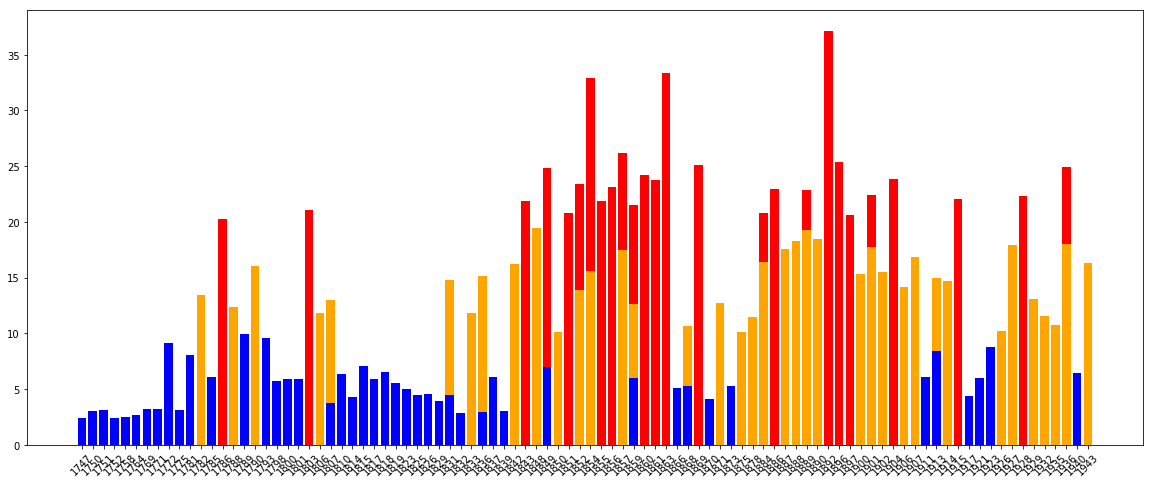

In [82]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=45)
plt.bar(x=year_clas.index, 
        height=year_clas["Classicality"], 
        width=0.8,
        color=plot_colors)